<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/Sequential_Modelling_EEG_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [52]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing import image
# from sklearn.model_selection import train_test_split

In [53]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode='coarse')

(32, 32, 3)

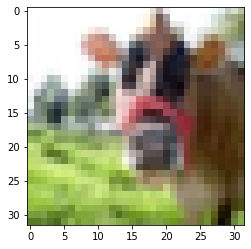

In [54]:
plt.imshow(train_images[0])
train_images[0].shape

In [55]:
train_labels[0]

array([11])

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
import json

with open('/content/gdrive/MyDrive/cifar100_fine_labels.json', 'r') as fine_labels:
    cifar100_fine_labels = json.load(fine_labels)

In [58]:
len(cifar100_fine_labels)

100

# Modelling

In [59]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Input, Flatten

In [60]:
num_classes = 100

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [61]:
def get_generator(features, labels, batch_size = 1):
  for n in range(features.shape[0]//batch_size):
    yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])

In [62]:
def get_cyclic_generator(features, labels, batch_size = 1):
  while True:
    for n in range(features.shape[0]//batch_size):
      yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])
    permuted = np.random.permutation(len(features))
    features = features[permuted]
    labels = labels[permuted]

In [63]:
train_batch_size = 10
train_generator = get_generator(train_images, train_labels, batch_size = train_batch_size)
train_generator_cyclic = get_cyclic_generator(train_images, train_labels, batch_size = train_batch_size)

In [64]:
images, labels = next(train_generator)

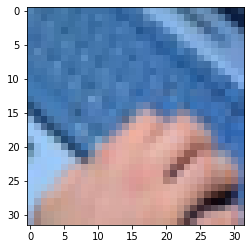

In [65]:
images, labels = next(train_generator)
image_unbatched = images[0,:,:,:]
plt.imshow(image_unbatched)

## Data Augmentation

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
def func_monochrome(x):
  def func_bw(a):
    average_pixel = np.mean(a)
    return [average_pixel, average_pixel, average_pixel]
  x = np.apply_along_axis(func_bw, -1, x)
  return x

In [68]:
data_generator = ImageDataGenerator(
    preprocessing_function = func_monochrome,
    rotation_range = 180,
    rescale = (1/255.0),
    horizontal_flip = False,
    vertical_flip = False,
)

data_generator.fit(train_images)

In [69]:
data_generator_iterable = data_generator.flow(train_images, train_labels, batch_size = 10, shuffle = False)

In [70]:
# def get_sequential_model():

#   model = tf.keras.Sequential()
#   model.add(Input((32, 32, 3)))
#   model.add(Conv2D(16, (16, 16), padding='same', activation='relu',))
#   model.add(MaxPool2D((16,16)))
#   model.add(Conv2D(16, (16, 16), padding='same', activation='relu',))
#   model.add(MaxPool2D((8,8)))
#   model.add(Conv2D(8, (8, 8), padding='same', activation='relu'))
#   model.add(MaxPool2D((4,4)))
#   model.add(Conv2D(4, (4, 4), padding='same', activation='relu'))
#   model.add(Flatten())
#   model.add(Dense(16, activation='relu'))
#   model.add(Dense(8, activation='relu'))
#   model.add(Dense(100, activation='softmax'))

#   return model;


def get_sequential_model():

  model = tf.keras.Sequential()
  model.add(Input((32,32,3)))
  # model.add(Conv2D(16, (16, 16), padding='same', activation='relu'))
  # model.add(MaxPooling2D((8,8)))
  model.add(Conv2D(8, (8, 8), padding='same', activation='relu'))
  model.add(MaxPool2D((4,4)))
  model.add(Conv2D(8, (8, 8), padding='same', activation='relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(4, (4, 4), padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(100, activation='softmax'))

  return model


# def get_sequential_model():

#   model = tf.keras.Sequential()
#   model.add(Input((32, 32, 3)))
#   model.add(Conv2D(8, (8, 8), padding='same', activation='relu',))
#   model.add(MaxPool2D((4,4)))
#   # model.add(Conv2D(8, (8, 8), padding='same', activation='relu'))
#   # model.add(MaxPool2D((2,2)))
#   model.add(Conv2D(4, (4, 4), padding='same', activation='relu'))
#   model.add(Flatten())
#   # model.add(Dense(400, activation='relu'))
#   model.add(Dense(200, activation='relu'))
#   model.add(Dense(100, activation='softmax'))

#   return model;

In [71]:
model = get_sequential_model()
# model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', 'val_acc'])
# model.summary()

In [72]:
optimizer = tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [73]:
train_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [74]:
train_steps_per_epoch = data_generator_iterable.n // data_generator_iterable.batch_size
# val_steps = val_generator.n // val_generator.batch_size
# print('Train Steps per Epoch: ', train_steps_per_epoch, '\n', 'Validation Steps', val_steps)

In [75]:
train_steps_per_epoch = len(train_images) // train_batch_size
print(train_steps_per_epoch)

# history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch)
history = model.fit(train_generator_cyclic, steps_per_epoch=train_steps_per_epoch, epochs = 10)

5000
Epoch 1/10
5000/5000 [==============================] - 19s 4ms/step - loss: 3.0381 - acc: 0.0748
Epoch 2/10
5000/5000 [==============================] - 19s 4ms/step - loss: 2.6950 - acc: 0.1469
Epoch 3/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.5804 - acc: 0.1862
Epoch 4/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.5131 - acc: 0.2082
Epoch 5/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.4689 - acc: 0.2238
Epoch 6/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.4371 - acc: 0.2354
Epoch 7/10
5000/5000 [==============================] - 19s 4ms/step - loss: 2.4171 - acc: 0.2418
Epoch 8/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.3915 - acc: 0.2482
Epoch 9/10
5000/5000 [==============================] - 19s 4ms/step - loss: 2.3610 - acc: 0.2578
Epoch 10/10
5000/5000 [==============================] - 18s 4ms/step - loss: 2.3421 - acc: 0.2617


In [76]:
y_0 = model.predict(images[0][np.newaxis, ...])
print(np.squeeze(y_0, axis = 0))
# print('\n')
print(labels[0])

[6.8164960e-02 1.2623374e-01 1.8182486e-02 2.5706235e-02 1.4198886e-02
 3.5018619e-02 2.5504537e-02 4.5440037e-02 3.0435685e-02 7.5869061e-02
 5.9591237e-02 4.9164973e-02 4.1677717e-02 5.2947570e-02 2.9771807e-02
 8.2911447e-02 5.3857241e-02 3.1474724e-02 6.5166555e-02 6.8682484e-02
 4.8917046e-17 2.4021391e-16 5.6311975e-17 4.5192246e-16 6.2655411e-17
 9.4522141e-14 1.7577106e-16 2.8322691e-16 2.8262266e-15 1.6975725e-16
 5.9641141e-16 5.7773989e-16 8.5719263e-16 3.5032708e-18 9.6695620e-17
 8.3197080e-16 8.2365621e-16 4.0590970e-16 1.1510913e-16 3.2019465e-16
 6.8938873e-16 2.9466222e-16 4.8462021e-16 2.3944541e-16 5.7606492e-17
 1.4461236e-16 2.3483560e-16 2.0791873e-16 2.4825069e-16 1.3406843e-16
 6.9912630e-17 4.0153899e-16 1.7860967e-15 2.0988946e-16 8.7980253e-17
 4.5490958e-16 1.6850567e-15 4.8370965e-16 7.6899779e-17 1.5235236e-16
 1.3088632e-16 1.9706915e-16 1.4356747e-16 7.8835246e-16 4.5794963e-16
 1.2936489e-16 2.1670164e-16 4.3606768e-16 1.3604314e-16 3.9434524e-16
 4.469